In [41]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import graphviz
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from MakeDataset import *

In [42]:
import numpy as np

XX_tr = np.sqrt(np.sum(X_train**2, axis=2))
XX_ts=np.sqrt(np.sum(X_test**2, axis=2))


In [43]:
print(XX_tr.shape)
print(XX_ts.shape)

(126, 500)
(54, 500)


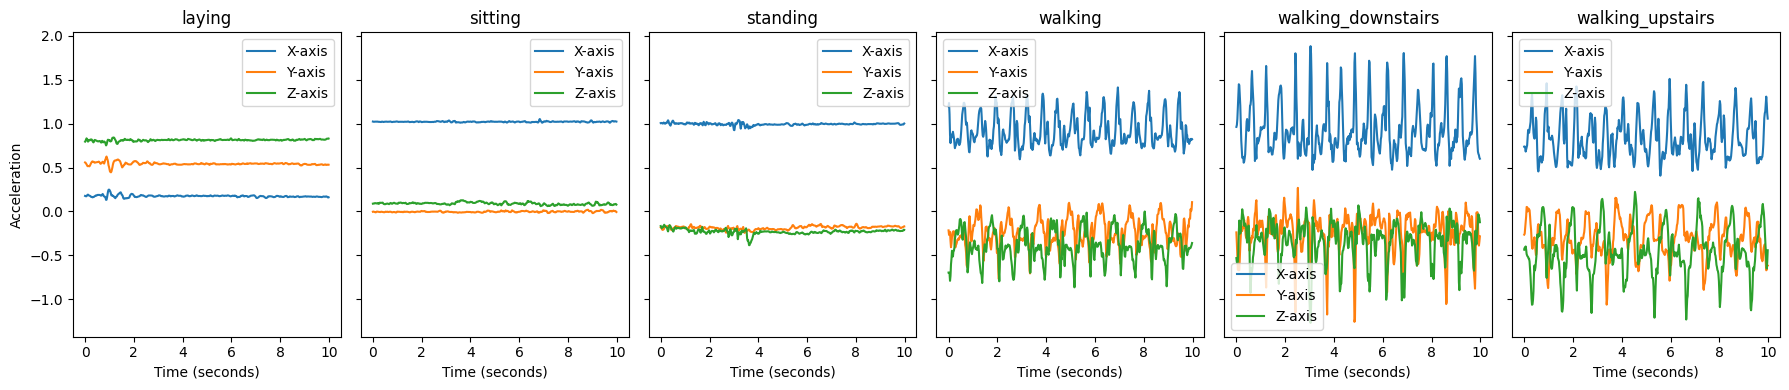

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Initialize dictionary to hold data
df = {}
activities = ['laying', 'sitting', 'standing', 'walking', 'walking_downstairs', 'walking_upstairs']

# Load data for each activity into the dictionary
for activity in activities:
    df[activity] = pd.read_csv(f"data+scripts/Combined/Train/{activity.upper()}/Subject_14.csv")

# Create subplots to visualize waveforms
fig, axes = plt.subplots(1, 6, figsize=(18, 4), sharey=True)

# Define the number of samples to plot (corresponding to 10 seconds at 50Hz)
num_samples = 500
sampling_rate = 50  # 50Hz

for i, activity in enumerate(activities):
    # Extract the first 500 samples for each activity
    data = df[activity].iloc[:num_samples]
    # Extract x, y, z components
    x = data.iloc[:, 0]
    y = data.iloc[:, 1]
    z = data.iloc[:, 2]

    # Create time axis in seconds
    time = range(num_samples)  # 0 to 499 samples
    time_seconds = [t / sampling_rate for t in time]  # Convert samples to seconds

    # Plot the waveform for each activity
    axes[i].plot(time_seconds, x, label='X-axis')
    axes[i].plot(time_seconds, y, label='Y-axis')
    axes[i].plot(time_seconds, z, label='Z-axis')
    axes[i].set_title(activity)
    axes[i].set_xlabel('Time (seconds)')
    if i == 0:
        axes[i].set_ylabel('Acceleration')
    axes[i].legend()

plt.tight_layout()
plt.show()


By seeing the plot we can clearly differentiate between the dynamic activites and static activities, as the peaks in dynamic activities are more than peaks in static activities. And between laying,sitting and standing we can clearly see that acc_x in sittitng is higher than acc_y & acc_z compared to laying and standing. And the peaks of acc_x in walking downstairs is higher than peaks of walking and walking upstairs.

In [45]:
# Q2

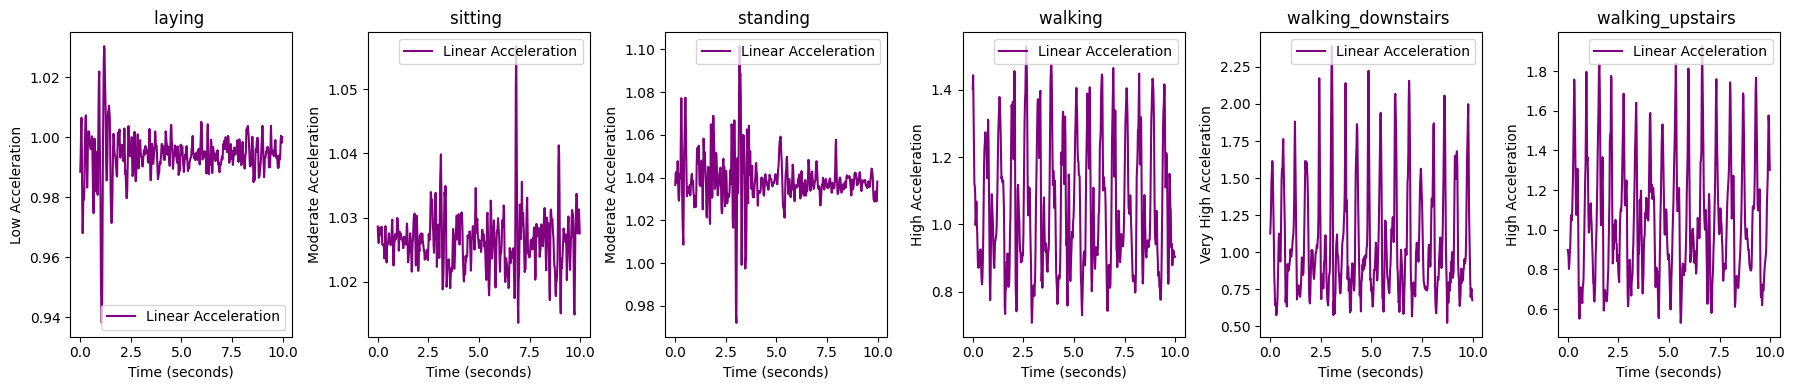

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Initialize dictionary to hold data
df = {}
activities = ['laying', 'sitting', 'standing', 'walking', 'walking_downstairs', 'walking_upstairs']

# Load data for each activity into the dictionary
for activity in activities:
    df[activity] = pd.read_csv(f"data+scripts/Combined/Train/{activity.upper()}/Subject_14.csv")

# Create subplots to visualize linear acceleration waveforms
fig, axes = plt.subplots(1, 6, figsize=(18, 4), sharey=False)

# Define the number of samples to plot (corresponding to 10 seconds at 50Hz)
num_samples = 500
sampling_rate = 50  # 50Hz

# Define custom y-axis labels for each activity
y_labels = {
    'laying': 'Low Acceleration',
    'sitting': 'Moderate Acceleration',
    'standing': 'Moderate Acceleration',
    'walking': 'High Acceleration',
    'walking_downstairs': 'Very High Acceleration',
    'walking_upstairs': 'High Acceleration'
}

for i, activity in enumerate(activities):
    # Extract the first 500 samples for each activity
    data = df[activity].iloc[:num_samples]
    # Extract x, y, z components
    x = data.iloc[:, 0]
    y = data.iloc[:, 1]
    z = data.iloc[:, 2]

    # Create time axis in seconds
    time = range(num_samples)  # 0 to 499 samples
    time_seconds = [t / sampling_rate for t in time]  # Convert samples to seconds

    # Calculate linear acceleration magnitude
    linear_acceleration = np.sqrt(x**2 + y**2 + z**2)

    # Plot linear acceleration magnitude
    axes[i].plot(time_seconds, linear_acceleration, color='purple', label='Linear Acceleration')
    axes[i].set_title(f'{activity} ')
    axes[i].set_xlabel('Time (seconds)')
    
    # Set different y-axis labels based on activity
    axes[i].set_ylabel(y_labels[activity])

    axes[i].legend()

plt.tight_layout()
plt.show()


We can visually distinguish between static and dynamic activities by looking at the plot of their linear acceleration. This is by seeing the waveforms, the maximum and minimum values of acceleration of static and dynamic activities. Since by direct visualisation these activities can be differentiated so there is no must of using Machine Learning models. However we can us decision tree to differentiarte between them by differentiating based on their peak values.

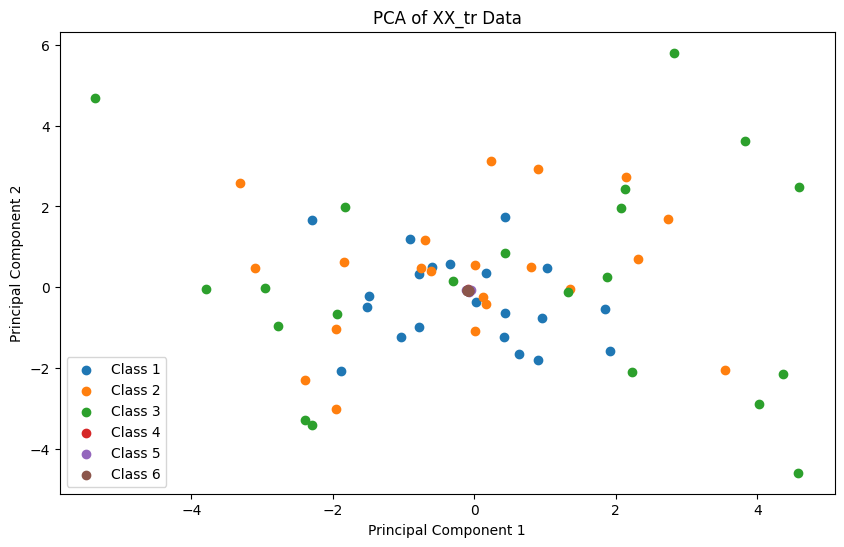

In [47]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming XX_tr and y_train are already defined
# XX_tr: 2D NumPy array, y_train: Labels corresponding to XX_tr

# Apply PCA to reduce the data to 2 components
pca = PCA(n_components=2)
XX_tr_pca = pca.fit_transform(XX_tr)

# Convert y_train to a 1D array if it's not already
# y_train = np.array(y_train).flatten()

# Create a DataFrame for easy plotting
df_pca = pd.DataFrame(data=XX_tr_pca, columns=['PC1', 'PC2'])
df_pca['Label'] = y_train

# Plotting
plt.figure(figsize=(10, 6))
for label in np.unique(y_train):
    plt.scatter(df_pca[df_pca['Label'] == label]['PC1'],
                df_pca[df_pca['Label'] == label]['PC2'],
                label=f'Class {label}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of XX_tr Data')
plt.legend()
plt.show()


In [48]:
import tsfel
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

# Assuming XX_tr and XX_ts are already defined (after the magnitude calculation)
# Convert the NumPy arrays to DataFrames for easier handling
df_train_acc = pd.DataFrame(XX_tr)
df_test_acc = pd.DataFrame(XX_ts)

# Retrieve a pre-defined feature configuration file from TSFEL
cfg = tsfel.get_features_by_domain()

# Function to extract features for a single time series instance
def extract_features_for_instance(row):
    return tsfel.time_series_features_extractor(cfg, row, verbose=0)

# Parallel processing: Extract features for each row in parallel
tsfel_train_x = pd.concat(Parallel(n_jobs=-1)(delayed(extract_features_for_instance)(df_train_acc.iloc[i, :]) for i in range(len(df_train_acc))), ignore_index=True)
tsfel_test_x = pd.concat(Parallel(n_jobs=-1)(delayed(extract_features_for_instance)(df_test_acc.iloc[i, :]) for i in range(len(df_test_acc))), ignore_index=True)

# Check the shapes to ensure successful feature extraction
print("Training set TSFEL features shape:", tsfel_train_x.shape)
print("Testing set TSFEL features shape:", tsfel_test_x.shape)

# Now tsfel_train_x and tsfel_test_x contain the extracted features


Training set TSFEL features shape: (126, 384)
Testing set TSFEL features shape: (54, 384)


In [49]:
# Convert XX_tr back to DataFrame if it was not already
df_train_acc = pd.DataFrame(XX_tr)
df_test_acc = pd.DataFrame(XX_ts)

# Combine the original features with the TSFEL-extracted features
combined_train_x = pd.concat([df_train_acc, tsfel_train_x], axis=1)
combined_test_x = pd.concat([df_test_acc, tsfel_test_x], axis=1)

# Check the shape of the combined features
print("Combined Training set features shape:", combined_train_x.shape)
print("Combined Testing set features shape:", combined_test_x.shape)


Combined Training set features shape: (126, 884)
Combined Testing set features shape: (54, 884)


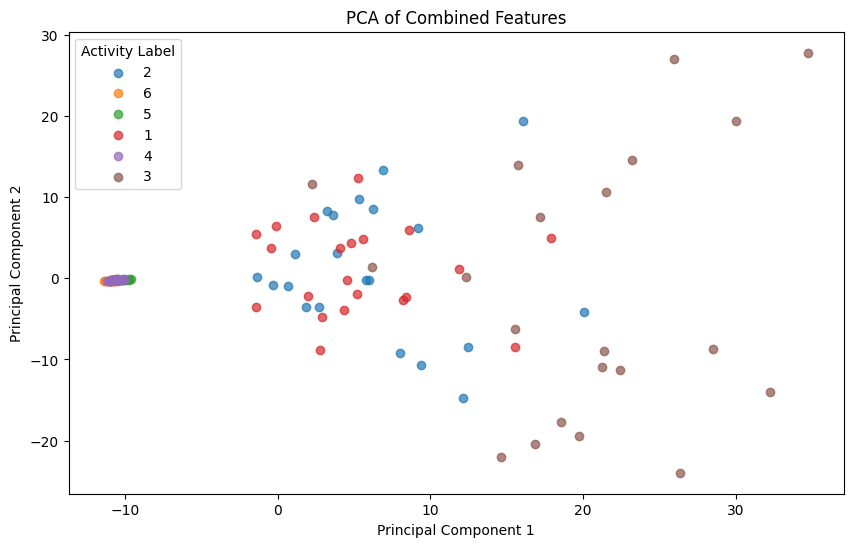

In [50]:


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Convert all column names to strings
combined_train_x.columns = combined_train_x.columns.astype(str)
combined_test_x.columns = combined_test_x.columns.astype(str)

# Standardize the combined training and testing features
scaler = StandardScaler()
combined_train_x_scaled = scaler.fit_transform(combined_train_x)
combined_test_x_scaled = scaler.transform(combined_test_x)

# Apply PCA to reduce to 2 principal components
pca = PCA(n_components=2)
train_pca = pca.fit_transform(combined_train_x_scaled)
test_pca = pca.transform(combined_test_x_scaled)

# Create DataFrame for easy plotting and add labels
df_train_pca = pd.DataFrame(data=train_pca, columns=['PC1', 'PC2'])
df_train_pca['Label'] = y_train.flatten()  # Directly flatten and assign

# Define a color map with darker colors
colors = plt.get_cmap('tab10').colors

# Plotting the PCA result
plt.figure(figsize=(10, 6))
for i, label in enumerate(df_train_pca['Label'].unique()):
    plt.scatter(df_train_pca[df_train_pca['Label'] == label]['PC1'],
                df_train_pca[df_train_pca['Label'] == label]['PC2'],
                label=label, color=colors[i], alpha=0.7)  # Increase alpha for better visibility

plt.title('PCA of Combined Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="Activity Label")
plt.show()


Explained variance ratio: [0.50781172 0.0658068 ]


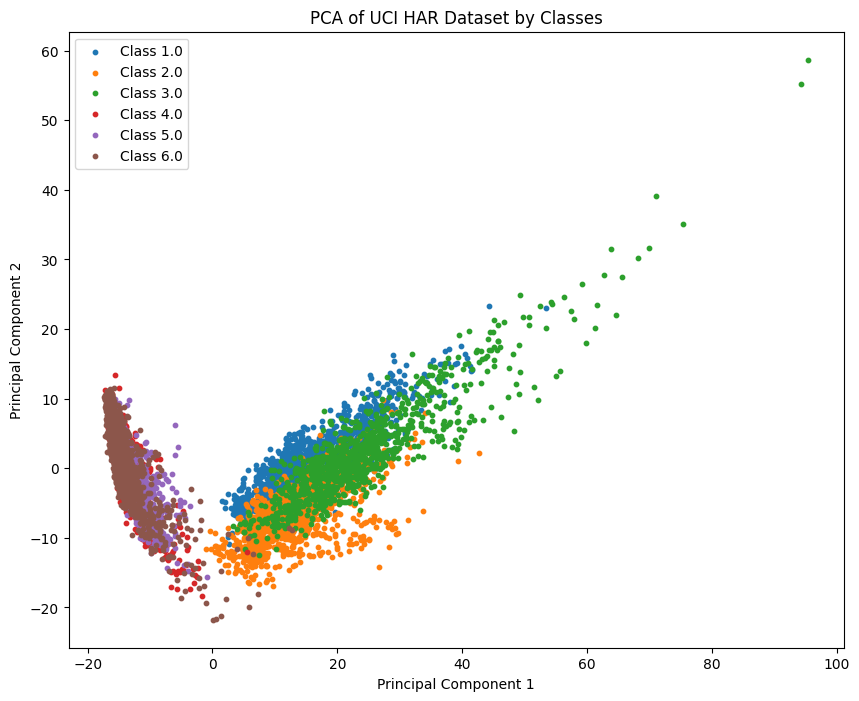

In [51]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load your dataset (replace with your actual file paths)
X_train1 = np.loadtxt('data_scripts/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt')  # Replace with actual path
y_train1 = np.loadtxt('data_scripts/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt') 

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train1)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components
X_pca = pca.fit_transform(X_train_scaled)

# Print explained variance ratio to understand how much variance is captured by the two components
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Get the unique classes (activities or subjects)
classes = np.unique(y_train1)

# Create a scatter plot with different colors for each class
plt.figure(figsize=(10, 8))
for class_label in classes:
    plt.scatter(
        X_pca[y_train1 == class_label, 0], 
        X_pca[y_train1 == class_label, 1], 
        label=f'Class {class_label}', 
        s=10  # Customize marker size
    )

plt.title('PCA of UCI HAR Dataset by Classes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()  # Show a legend to differentiate classes
plt.show()





C:\Users\shash\AppData\Local\Temp\ipykernel_15116\197992758.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train2 = pd.read_csv("data_scripts/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None)


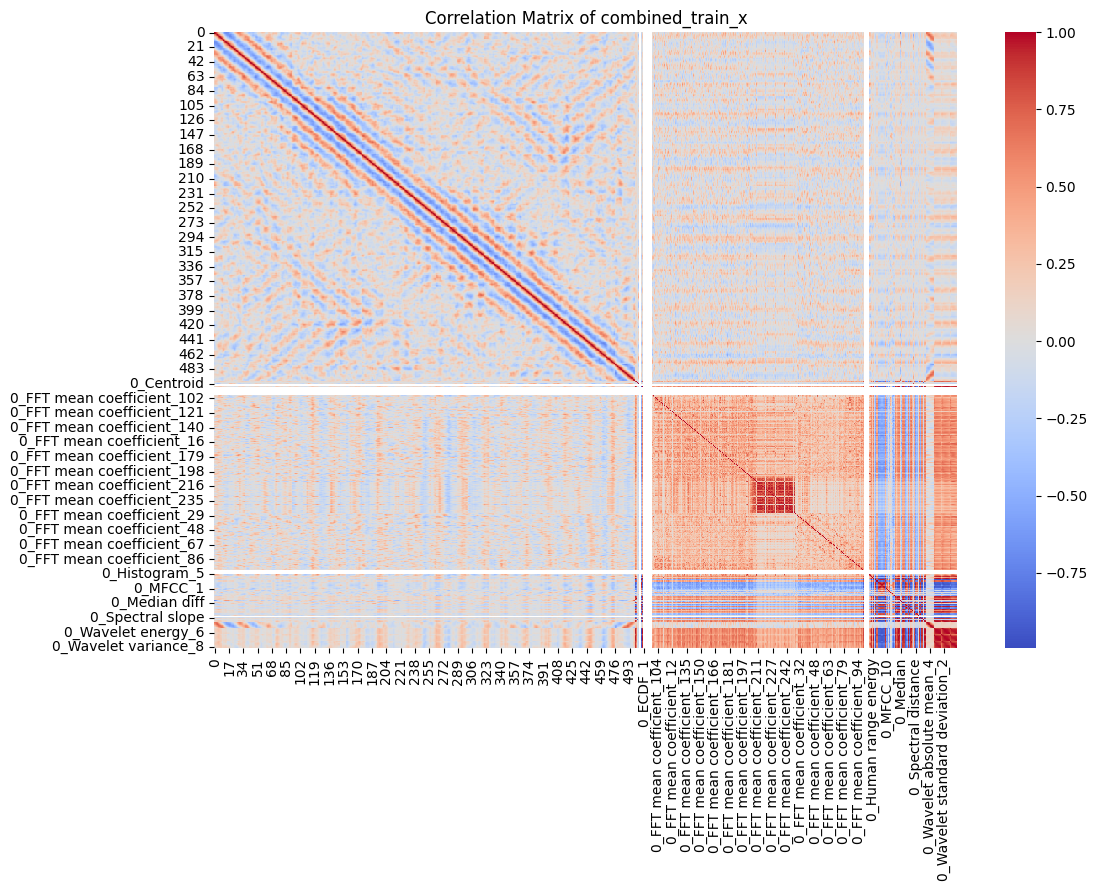

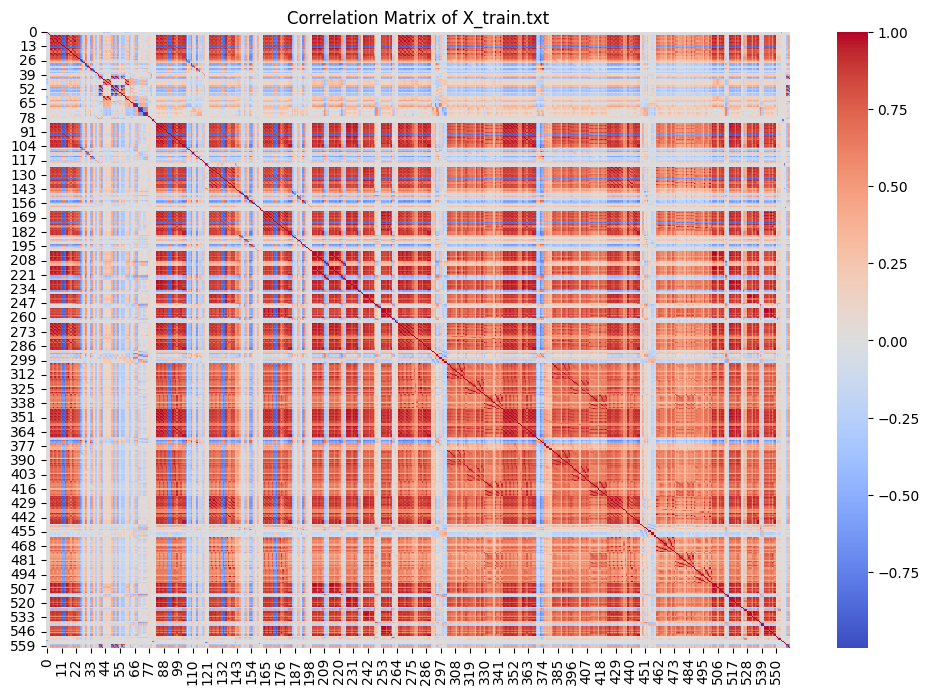

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load X_train.txt (assuming it's in the same format as other files)
X_train2 = pd.read_csv("data_scripts/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None)

# Calculate correlation matrix for combined_train_x
combined_corr_matrix = combined_train_x.corr()

# Calculate correlation matrix for X_train
X_train_corr_matrix = X_train2.corr()

# Plot the correlation matrices
plt.figure(figsize=(12, 8))
sns.heatmap(combined_corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Correlation Matrix of combined_train_x')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(X_train_corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Correlation Matrix of X_train.txt')
plt.show()


In [54]:
# 1) Dataset modified with the help of tsefl
# - In this dataset 35,198 the FFT features that are obtained using tsefl is highly corelated with the FFT features between 32 and 211

In [ ]:
import pandas as pd
import numpy as np

# Load X_train.txt (assuming it's in the same format as other files)
X_train = pd.read_csv("data_scripts/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None)

# Assuming combined_train_x is defined elsewhere in your code
# combined_train_x = ...

# Calculate correlation matrix for combined_train_x
combined_corr_matrix = combined_train_x.corr()

# Calculate correlation matrix for X_train
X_train_corr_matrix = X_train.corr()

# Print the correlation matrices
print("Correlation Matrix of combined_train_x:")
print(combined_corr_matrix)

print("\nCorrelation Matrix of X_train.txt:")
print(X_train_corr_matrix)

# Optionally, you can save these matrices to CSV files
combined_corr_matrix.to_csv('combined_corr_matrix.csv')
X_train_corr_matrix.to_csv('X_train_corr_matrix.csv')


C:\Users\shash\AppData\Local\Temp\ipykernel_15116\2383745959.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv("data_scripts/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None)


Correlation Matrix of combined_train_x:
                             0         1         2         3         4  \
0                     1.000000  0.954359  0.812292  0.581013  0.407361   
1                     0.954359  1.000000  0.920331  0.711992  0.529719   
2                     0.812292  0.920331  1.000000  0.911819  0.758967   
3                     0.581013  0.711992  0.911819  1.000000  0.940396   
4                     0.407361  0.529719  0.758967  0.940396  1.000000   
...                        ...       ...       ...       ...       ...   
0_Wavelet variance_5  0.072084  0.171059  0.182323  0.200868  0.224468   
0_Wavelet variance_6  0.032233  0.135755  0.154538  0.174203  0.197978   
0_Wavelet variance_7 -0.003165  0.105579  0.133935  0.151817  0.171279   
0_Wavelet variance_8 -0.029028  0.084565  0.122903  0.135319  0.145728   
0_Zero crossing rate       NaN       NaN       NaN       NaN       NaN   

                             5         6         7         8         9 